## Paper Machine Sheet Break Prediction with CNN model.  Subset where x28 feature is 96.
## Updated

## This model only uses 3 classes: 0 for normal, 1 for warning, & 2 for a fault vs. the prior model with 5 warning classes.  This model performs better. 

### Reference and Licence

### Dataset: Rare Event Classification in Multivariate Time Series
 ### 2018-10-01  Chitta Ranjan, Markku Mustonen, Kamran Paynabar, Karim Pourak
### https://deeplearn.org/arxiv/48599/dataset:-rare-event-classification-in-multivariate-time-series

### Summary - Updated Notebook with corrections.
#### This is an update to prior analysis using the X28 = 96 Categorical subset and has improved charts for performance, some minor data cleaning, and a different NN Optimizer.

This notebook looks at using CNN to predict an upcoming process fault (paper break) in a paper machine.

The dataset is subdivided to focus on the most frequent samples set where feature x28 is eqal to 96.  Samples ahead of a break are relabelled as class 1 and the break is relabelled as 2.  Other normal samples remain labelled as 0.

The EDA notbook shows noticable difference in many features depending on the categorical feature x28.

# Results
The results are mixed with the CNN model having about a 11% false positive rate (when the train test split is 65-35), categorizing them as a warning state equivalent to a label value of 1.
The model does a good job of detecting the actual break sample and a mixed job at identifying warning labels.  About half of these are classified as 0 (normal).  This may be indicative of variability in samples prior to a break rather than a steady divergence from normal operation.  Also, the misclassification of normal state as warning may be driven by deviation in normal operating condition that does not deviate to a paper break condition.

The objective to predict a warning several time period ahead of a break is somewhat realized.  Subsequent trials may include PCA and/or a different reduced set of features, with and without derivatives of the sample values.

This notebook does not balance the samples by reducing the number of normal samples.  Attempts at that showed overfitting and poor results on the test set, particularly with false positives.  The smaller normal sample size did not allow the model to train over the normal sample space.

Instead, I have used a modified argmax method in the prediction using a threshold probability ( from predict_proba ) for normals equal to their percentage in the dataset and a corresponding lower threshold for the warning and fault classes.

## Workflow
#### Clean data based on EDA notebook
- Remove low impact features based on Random Forest feature importance and those with interactions shifted with x22 & x28. 
- Retain features:
     x2, x3, x9-x13, x31, x41, x42, x44-x47, and x59 plus x22, x23, x35, x52, x53, x54
- Segregate data on the most frequent categorical-like feature in: x28 == 96
- drop short periods between faults - see below.
- drop fault conditions that are separted from the running condition by missing data.
- Create two derivative sets with time relative to the sensor position features, dF/dt & dF/dt^2
- Scale the data
- Combine the data into time snap shots with 6 time periods and the position and derivatives stacked in each image.
    Each successive image is offset by one time slice (2 minutes) so an image overlaps part of its 5 preceeding images,
    with the exception the beginning, and immediately following a fault.
- Retain the original fault label 0/1, but relabel the fault label to 2, and the preceding 5 time slices to 1.
- Label each image as 0 or 1 or 2. 
- Buid a custom predict function to account for the imbalanced training & test sets.
- Split the data into train & test sets stratify on the 0, 1, & 2 labels.  The split will be random rather than front end, back end.
- Train the data with a CNN model.
- Evaluate performance on the test set and plot the entire month (Train & Test) intermingled with the model prediction.

### Note: Periods without 6 samples between faults will be dropped in this attempt.  These faults are indicative of start-up issues.  This attempt will focus on a steady state running condition.  These faults may be  included in furture notebooks with missing stable sample times replaced with prior relevant samples (eg. aligned with the x28 feature conditions) 

### Assumption, deviations in the process variables and in their derivatives can indicate a future sheet break (a break in the continuous sheet of paper).  Stacking the individual time slices into an 12 minute picture of time can provide a warning or liklihood of an upcoming sheet break more reliably than an individual time slice, similar to a LSTM model with multiple prior sample imputs.  

In [1]:
#Import General Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,  classification_report

from random import random

import matplotlib.pyplot as plt

In [2]:
from keras import Sequential, regularizers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
import livelossplot

Using TensorFlow backend.


In [3]:
df=pd.read_csv('processminer-rare-event-mts - data.csv')

In [4]:
df.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [5]:
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)

In [6]:
df['x28'].nunique()

8

In [7]:
df['x28'].value_counts()

96     6574
82     4378
118    2646
139    1807
84     1313
112    1235
93      419
51       26
Name: x28, dtype: int64

### The features behavior varies based on the x28 value, as seen in the EDA notebook.   So for the first model focus on the majority of occurrances of x28, where it is equal to 96.

### Drop columns, retain features from EDA work.

In [8]:
df = df[df['x28']==96]

df= df.drop(df[['x1', 'x4', 'x5', 'x6', 'x7', 'x8', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x24', 'x25', 'x26', 'x27', 'x29', 'x30', 'x32', 'x33', 'x34', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x43', 'x48', 'x49','x50', 'x51', 'x55', 'x56', 'x57', 'x58', 'x60', 'x61']], axis =1)

In [9]:
df.shape

(6574, 24)

In [10]:
df = df.drop(df[['x28']], axis=1)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6574 entries, 0 to 18397
Data columns (total 23 columns):
time    6574 non-null datetime64[ns]
y       6574 non-null int64
x2      6574 non-null float64
x3      6574 non-null float64
x9      6574 non-null float64
x10     6574 non-null float64
x11     6574 non-null float64
x12     6574 non-null float64
x13     6574 non-null float64
x22     6574 non-null float64
x23     6574 non-null float64
x31     6574 non-null float64
x35     6574 non-null float64
x41     6574 non-null float64
x42     6574 non-null float64
x44     6574 non-null float64
x45     6574 non-null float64
x46     6574 non-null float64
x47     6574 non-null float64
x52     6574 non-null float64
x53     6574 non-null float64
x54     6574 non-null float64
x59     6574 non-null float64
dtypes: datetime64[ns](1), float64(21), int64(1)
memory usage: 1.2 MB


#### There are 2 occasions of mislableled faults in the X28 = 96 subset. The break is labelled but there isn't a distruption in run time. These are at May 13 18:14 hours and May 14 09:30 hours. Reset the fault label to 0 for these.

In [12]:
print(df['y'][df['time']==pd.to_datetime('1999-05-13 18:14:00')], '\n', df['y'][df['time']==pd.to_datetime('1999-05-14 09:30:00')])

8475    1
Name: y, dtype: int64 
 8933    1
Name: y, dtype: int64


In [13]:
df['y'][df['time']==pd.to_datetime('1999-05-13 18:14:00')]=0
df['y'][df['time']==pd.to_datetime('1999-05-14 09:30:00')]=0

In [14]:
print(df['y'][df['time']==pd.to_datetime('1999-05-13 18:14:00')], '\n', df['y'][df['time']==pd.to_datetime('1999-05-14 09:30:00')])

8475    0
Name: y, dtype: int64 
 8933    0
Name: y, dtype: int64


#### There is a 68 minute gap from May 12 21:40 hours to a fault condition at 22:48 hours.  This fault will be removed since there are missing time slices corresponding with a warning state.

In [15]:
df = df[df['time'] != pd.to_datetime('1999-05-12 22:48:00')]
len(df)

6573

### Check the minimum number of samples between tear conditions

In [16]:
dfy = pd.DataFrame(columns = ['y', 'gaps'])
dfy['y'] = df['y'][df['y']==1]

Inds = dfy.index
gaps=[]
for i in range(len(Inds)):
    if i != 0:
        gaps.append(Inds[i] - Inds[i-1])
    else:
        gaps.append(Inds[i])
dfy['gaps'] = gaps
print('Mininmum samples between faults: ', min(dfy['gaps']))

dfy.head()

Mininmum samples between faults:  3


,y,gaps
259,1,259
2298,1,2039
2303,1,5
2308,1,5
2312,1,4


Number of occurances of less than 6 time samples between faults: 11


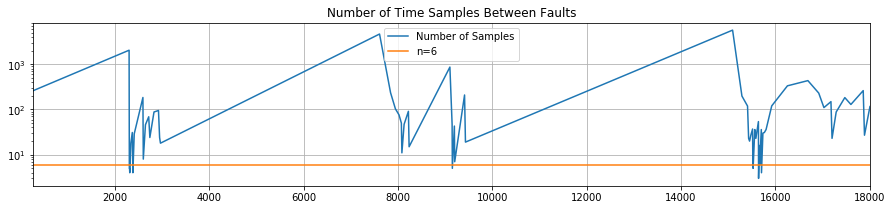

In [17]:
plt.figure(figsize=(15,3))
dfy['gaps'].plot(label='Number of Samples')
plt.plot([0, 18000], [6,6], label= 'n=6')
plt.title('Number of Time Samples Between Faults')
plt.yscale('log')
plt.grid()
plt.legend()
print(('Number of occurances of less than 6 time samples between faults: {}').format(sum(dfy['gaps']<=6)) )
plt.show()

The ramps in the above chart correspond to dropped data for x28 values not equal to 96.  The chart plot the original index on the x axis.

These 11 faults will be dropped form this iteration.  Future attempts could include the 5 sample cases, but the missing sample will need to be replaced with zeros or an avergae of normal samples.

In [18]:
# Drop the faults and related samples where there are fewer than 6 samples between faults
Ind_6 = dfy[dfy['gaps']<7].index
for i in Ind_6:
    for j in range( dfy.loc[i][1] ):
        df['y'].loc[i-j] = 10

df = df[df['y']!=10]

print('Number of remaining faults is: ', df['y'].sum())
print('remaing shape of df is: ', df.shape)       

Number of remaining faults is:  58
remaing shape of df is:  (6521, 23)


In [19]:
# Reset the index
df=df.reset_index()

In [20]:
master_index = df['time']

In [21]:
# Repeat to get a new dfy with remaining faults and gaps
dfy2 = pd.DataFrame(columns = ['y', 'gaps'])
dfy2['y'] = df['y'][df['y']==1]

Inds2 = dfy2.index
gaps=[]
for i in range(len(Inds2)):
    if i != 0:
        gaps.append(Inds2[i] - Inds2[i-1])
    else:
        gaps.append(Inds2[i])
dfy2['gaps'] = gaps
print('Mininmum samples between faults: ', min(dfy2['gaps']), 'Maximum samples between faults is: ', max(dfy2['gaps']) )

dfy2.head()

Mininmum samples between faults:  7 Maximum samples between faults is:  865


,y,gaps
259,1,259
536,1,277
554,1,18
585,1,31
593,1,8


Number of occurances of less than 6 time samples between faults: 0


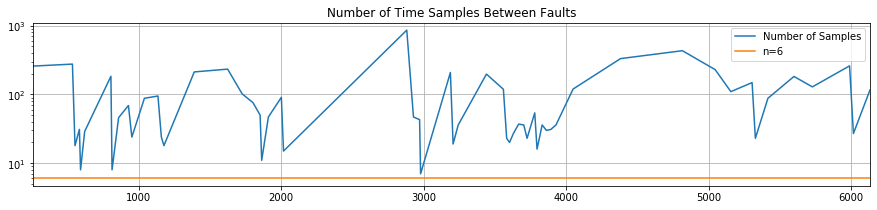

In [22]:
plt.figure(figsize=(15,3))
dfy2['gaps'].plot(label='Number of Samples')
plt.plot([0, 18000], [6,6], label= 'n=6')
plt.title('Number of Time Samples Between Faults')
plt.yscale('log')
plt.grid()
plt.legend()
print(('Number of occurances of less than 6 time samples between faults: {}').format( sum(dfy2['gaps']<=6)) )
plt.show()

### Now build a single and double derivative ('velocity' & 'acceleration') datasets, fixing the time delta at 2 (minutes) and ignore the time skipped after a sheet break.  These values at restart will be set to zero.

In [23]:
df.columns

Index(['index', 'time', 'y', 'x2', 'x3', 'x9', 'x10', 'x11', 'x12', 'x13',
       'x22', 'x23', 'x31', 'x35', 'x41', 'x42', 'x44', 'x45', 'x46', 'x47',
       'x52', 'x53', 'x54', 'x59'],
      dtype='object')

In [24]:
vel_cols = ['time', 'y']
acc_cols = ['time', 'y']
for item in df.columns[3:]:
    vel_cols.append(item + '_vel')
    acc_cols.append(item + '_acc')

In [25]:
df_vel = pd.DataFrame(columns = vel_cols)
df_vel['time'] = df['time']
df_vel['y'] = df['y']

df_vel.iloc[0,2:] = 0
df_vel.iloc[1:,2:] = (np.array( df.iloc[1:,3:]) - np.array( df.iloc[0:-1,3:]) )/2

# Show df_vel at the first fault, index 259
df_vel[257:262]

,time,y,x2_vel,x3_vel,x9_vel,x10_vel,x11_vel,x12_vel,x13_vel,x22_vel,...,x41_vel,x42_vel,x44_vel,x45_vel,x46_vel,x47_vel,x52_vel,x53_vel,x54_vel,x59_vel
257,1999-05-01 08:34:00,0,0.0910975,0.0113925,0.005036,0,-0.140537,-0.042037,-1.87471,0,...,2.39941,0.004113,-3.64258,0.126879,-0.303735,-2.99448,0.0023195,0,-4.7e-05,0.38213
258,1999-05-01 08:36:00,0,0.003866,-0.0877905,0,0,0.047608,-0.077133,0.0585785,0,...,-0.512451,0.004113,-22.3955,0.525498,-0.263405,0.09155,0.0023195,0,-4.7e-05,0.482708
259,1999-05-01 08:38:00,1,-4.7321,-4.37831,0,0,-0.0698975,0.053729,1.6747,-1.00101,...,0.114075,0.004113,-11.0068,-0.612702,0.209844,-0.32959,0.002319,0,-4.75e-05,0.486832
260,1999-05-01 10:50:00,0,4.67238,4.37902,0,0.029908,-0.549845,-0.845051,-32.2076,1.49162,...,1.81305,0.271455,43.9053,-0.240597,-0.109865,-11.2415,-2.47522,-6.72949,-0.0721685,-0.0253905
261,1999-05-01 10:52:00,0,-0.541601,-0.580691,0,0,0.726049,0.066002,1.44137,-0.0020795,...,-0.863831,0.004113,-16.1191,0.243199,0.229622,7.05057,0.007324,0.0286865,0.0004155,-0.194592


In [26]:
df_vel[257:262]

,time,y,x2_vel,x3_vel,x9_vel,x10_vel,x11_vel,x12_vel,x13_vel,x22_vel,...,x41_vel,x42_vel,x44_vel,x45_vel,x46_vel,x47_vel,x52_vel,x53_vel,x54_vel,x59_vel
257,1999-05-01 08:34:00,0,0.0910975,0.0113925,0.005036,0,-0.140537,-0.042037,-1.87471,0,...,2.39941,0.004113,-3.64258,0.126879,-0.303735,-2.99448,0.0023195,0,-4.7e-05,0.38213
258,1999-05-01 08:36:00,0,0.003866,-0.0877905,0,0,0.047608,-0.077133,0.0585785,0,...,-0.512451,0.004113,-22.3955,0.525498,-0.263405,0.09155,0.0023195,0,-4.7e-05,0.482708
259,1999-05-01 08:38:00,1,-4.7321,-4.37831,0,0,-0.0698975,0.053729,1.6747,-1.00101,...,0.114075,0.004113,-11.0068,-0.612702,0.209844,-0.32959,0.002319,0,-4.75e-05,0.486832
260,1999-05-01 10:50:00,0,4.67238,4.37902,0,0.029908,-0.549845,-0.845051,-32.2076,1.49162,...,1.81305,0.271455,43.9053,-0.240597,-0.109865,-11.2415,-2.47522,-6.72949,-0.0721685,-0.0253905
261,1999-05-01 10:52:00,0,-0.541601,-0.580691,0,0,0.726049,0.066002,1.44137,-0.0020795,...,-0.863831,0.004113,-16.1191,0.243199,0.229622,7.05057,0.007324,0.0286865,0.0004155,-0.194592


#### As shown above in time steps 259 to 260, there is a re-start of the process and the derivative ('velocity') is not representative.
#### Therefore, reset values after each sheet break on df_vel to zero.   This will also eliminate large swings in the double derivative.  
#### Then repeat with the 'acceleration' data.

In [27]:
Indx = 0

for row in range(len(dfy2)):
    gap = dfy2.iloc[row,1]
    Indx = Indx + gap 
    df_vel.iloc[Indx+1, 2:] = 0

df_vel[257:262]

,time,y,x2_vel,x3_vel,x9_vel,x10_vel,x11_vel,x12_vel,x13_vel,x22_vel,...,x41_vel,x42_vel,x44_vel,x45_vel,x46_vel,x47_vel,x52_vel,x53_vel,x54_vel,x59_vel
257,1999-05-01 08:34:00,0,0.0910975,0.0113925,0.005036,0,-0.140537,-0.042037,-1.87471,0,...,2.39941,0.004113,-3.64258,0.126879,-0.303735,-2.99448,0.0023195,0,-4.7e-05,0.38213
258,1999-05-01 08:36:00,0,0.003866,-0.0877905,0,0,0.047608,-0.077133,0.0585785,0,...,-0.512451,0.004113,-22.3955,0.525498,-0.263405,0.09155,0.0023195,0,-4.7e-05,0.482708
259,1999-05-01 08:38:00,1,-4.7321,-4.37831,0,0,-0.0698975,0.053729,1.6747,-1.00101,...,0.114075,0.004113,-11.0068,-0.612702,0.209844,-0.32959,0.002319,0,-4.75e-05,0.486832
260,1999-05-01 10:50:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,1999-05-01 10:52:00,0,-0.541601,-0.580691,0,0,0.726049,0.066002,1.44137,-0.0020795,...,-0.863831,0.004113,-16.1191,0.243199,0.229622,7.05057,0.007324,0.0286865,0.0004155,-0.194592


In [28]:
df_acc = pd.DataFrame(columns = acc_cols)
df_acc['time'] = df['time']
df_acc['y'] = df['y']

df_acc.iloc[0,2:] = 0
df_acc.iloc[1:,2:] = (np.array( df_vel.iloc[1:,2:]) - np.array( df_vel.iloc[0:-1,2:]) )/2

df_acc[257:262]

,time,y,x2_acc,x3_acc,x9_acc,x10_acc,x11_acc,x12_acc,x13_acc,x22_acc,...,x41_acc,x42_acc,x44_acc,x45_acc,x46_acc,x47_acc,x52_acc,x53_acc,x54_acc,x59_acc
257,1999-05-01 08:34:00,0,0.0937172,-0.003459,0.002518,0,-0.115919,-0.0170607,-2.0821,0,...,2.40973,0,-0.760742,0.19537,-0.383251,-4.07716,2.5e-07,0,0,0.0863498
258,1999-05-01 08:36:00,0,-0.0436157,-0.0495915,-0.002518,0,0.0940725,-0.017548,0.966644,0,...,-1.45593,0,-9.37646,0.19931,0.0201652,1.54301,-4.44089e-16,0,0,0.050289
259,1999-05-01 08:38:00,1,-2.36798,-2.14526,0,0,-0.0587527,0.065431,0.80806,-0.500503,...,0.313263,0,5.69434,-0.5691,0.236625,-0.21057,-2.5e-07,0,-2.5e-07,0.00206175
260,1999-05-01 10:50:00,0,2.36605,2.18916,0,0,0.0349488,-0.0268645,-0.837349,0.500503,...,-0.0570373,-0.0020565,5.50342,0.306351,-0.104922,0.164795,-0.0011595,0,2.375e-05,-0.243416
261,1999-05-01 10:52:00,0,-0.270801,-0.290345,0,0,0.363025,0.033001,0.720684,-0.00103975,...,-0.431916,0.0020565,-8.05957,0.121599,0.114811,3.52528,0.003662,0.0143433,0.00020775,-0.0972958


In [29]:
Indx = 0

for row in range(len(dfy2)):
    gap = dfy2.iloc[row,1]
    Indx = Indx + gap 
    df_acc.iloc[Indx+1, 2:] = 0

df_acc[257:262]

,time,y,x2_acc,x3_acc,x9_acc,x10_acc,x11_acc,x12_acc,x13_acc,x22_acc,...,x41_acc,x42_acc,x44_acc,x45_acc,x46_acc,x47_acc,x52_acc,x53_acc,x54_acc,x59_acc
257,1999-05-01 08:34:00,0,0.0937172,-0.003459,0.002518,0,-0.115919,-0.0170607,-2.0821,0,...,2.40973,0,-0.760742,0.19537,-0.383251,-4.07716,2.5e-07,0,0,0.0863498
258,1999-05-01 08:36:00,0,-0.0436157,-0.0495915,-0.002518,0,0.0940725,-0.017548,0.966644,0,...,-1.45593,0,-9.37646,0.19931,0.0201652,1.54301,-4.44089e-16,0,0,0.050289
259,1999-05-01 08:38:00,1,-2.36798,-2.14526,0,0,-0.0587527,0.065431,0.80806,-0.500503,...,0.313263,0,5.69434,-0.5691,0.236625,-0.21057,-2.5e-07,0,-2.5e-07,0.00206175
260,1999-05-01 10:50:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,1999-05-01 10:52:00,0,-0.270801,-0.290345,0,0,0.363025,0.033001,0.720684,-0.00103975,...,-0.431916,0.0020565,-8.05957,0.121599,0.114811,3.52528,0.003662,0.0143433,0.00020775,-0.0972958


In [30]:
df_acc.tail()

,time,y,x2_acc,x3_acc,x9_acc,x10_acc,x11_acc,x12_acc,x13_acc,x22_acc,...,x41_acc,x42_acc,x44_acc,x45_acc,x46_acc,x47_acc,x52_acc,x53_acc,x54_acc,x59_acc
6516,1999-05-28 23:58:00,0,-0.00770225,0.0195992,0,0,0.0209402,0.0398513,-1.38977,0,...,2.80719,0,18.1337,-0.496016,0.333078,0.0720978,0,0,1.11022e-16,-0.22411
6517,1999-05-29 00:00:00,0,-0.0511315,0.00378925,0,0,0.0154953,-0.0376838,0.882492,0,...,-3.71661,-2.5e-07,2.57325,0.336838,-0.163538,1.767,0,0,0,-0.13639
6518,1999-05-29 00:02:00,0,-0.007404,-0.095707,0,0,-0.0115078,0.035827,1.57059,0,...,-3.04925e-05,2.5e-07,0.185575,-0.0918552,0.0344188,-1.51482,0,0,0,0.291502
6519,1999-05-29 00:04:00,0,0.0380543,0.0700043,0,0,0.00627825,-0.00495976,-2.95881,0,...,0.165711,0,-0.000525,-0.0777415,0.167253,-0.687546,0,0,2.5e-07,0.0810525
6520,1999-05-29 00:06:00,0,0.0485175,0.038368,0.00251775,0,-0.0239777,-0.0155387,-0.494038,0,...,0.880768,0,0.0005,0.130964,-0.109592,-0.683945,0,0,-2.5e-07,-0.435448


### First determine the number of images.  Once the break condition sample is first recorded on an image, the break has occured and the next image will start with the following 5 samples.  Normal condition samples will appear on 5 images, whereas the break sample only appears on 1 image.

In [31]:
# image count is number of time periods less 5 if there are no break condition.
# take away the number of time periods for all situations where the gap between breaks is <= 6 
#    - retain this for when samples are not screened out
# take away 6 time periods, and therefore images when the image resets once a break reaches the image.

image_count = len(df) - 5 - sum(dfy2['gaps'][dfy2['gaps']<=6]) - 6*(sum(df['y']) - len(dfy2[dfy2['gaps']<=6]) )
image_count, (sum(df['y']) - len(dfy2[dfy2['gaps']<=5]) )

(6168, 58)

#### Drop the time and y value from the df, df_vel, and df_acc. Then scale the three df's.

In [32]:
df_s = df.drop(['index','time', 'y'], axis = 1)
df_vel_s = df_vel.drop(['time', 'y'], axis = 1)
df_acc_s = df_acc.drop(['time', 'y'], axis = 1)

#y_true = df[['y', 'time']].values
y_true = df['y']
print('Check, sum of y_true:', sum(y_true) )

Check, sum of y_true: 58


In [33]:
scaler = MinMaxScaler(feature_range=(0,1) )

df_s=scaler.fit_transform(df_s)
df_vel_s=scaler.fit_transform(df_vel_s)
df_acc_s=scaler.fit_transform(df_acc_s)

In [34]:
Ws, Wv, Wa = df_s.shape[1], df_vel_s.shape[1], df_acc_s.shape[1]
Ws, Wv, Wa

(21, 21, 21)

In [35]:
df_s.shape, df_vel_s.shape, df_acc_s.shape

((6521, 21), (6521, 21), (6521, 21))

### Build an image array with 6 measurement, 'velocity', & 'acceleration' time slices on each 12 minute time range image.

In [36]:
images = np.zeros((image_count,18,Ws))
Y = np.zeros((image_count)).astype(int)
lbl = np.zeros((image_count)).astype(int)
img_index = np.zeros((image_count)).astype(pd.Timestamp)

In [37]:
lbl.shape

(6168,)

In [38]:
#ADJUST TO 3 WARNING PERIODS AHEAD OF FAULT
# Build Image set with Y labels as 0 for normal, 1 for images 1-5 time periods in advance of actual fault and 2 for a fault.
# Build the image in one slice - 6 rows, of each position, velocity, & acceleration at a time, resetting after a break.

print('image#, first row, last row,         y')
i = 0


for c in range(image_count):
       
    images[c,0:6,:] = df_s[i:i+6,:]         # Load 6 rows of position values
    
    images[c,6:12,0:] = df_vel_s[i:i+6,:]   # Load 6 rows of 'velocity / first derivative' values
    
    images[c,12:18,0:] = df_acc_s[i:i+6,:]   # Load 6 rows of 'acceleration / second derivative' values
    
    lbl[c] = y_true[i+5]                    # label images with faults as 1
    img_index[c] = master_index[i+5]
    
    Y[c] = 1*(y_true[i+10]==1) + 1*(y_true[i+9]==1) + 1*(y_true[i+8]==1) + 1*(y_true[i+7]==1) + 1*(y_true[i+6]==1) + 2*(y_true[i+5]==1)

    if Y[c] == 2: 
        print(('{:^10}{:^14}{:^10}{:^10}').format(c, i, i+5, y_true[i+5])) 
        i = i + 6
    else:
        i = i + 1

print(('{:^10}{:^14}{:^10}{:^10}').format(c, i-1, i+5-1, y_true[i+5-1])) 

image#, first row, last row,         y
   254         254         259        1     
   526         531         536        1     
   539         549         554        1     
   565         580         585        1     
   568         588         593        1     
   592         617         622        1     
   771         801         806        1     
   774         809         814        1     
   815         855         860        1     
   879         924         929        1     
   898         948         953        1     
   981         1036        1041       1     
   1071        1131        1136       1     
   1090        1155        1160       1     
   1103        1173        1178       1     
   1311        1386        1391       1     
   1540        1620        1625       1     
   1637        1722        1727       1     
   1708        1798        1803       1     
   1753        1848        1853       1     
   1759        1859        1864       1     
   1801        1

In [39]:
c, i-1, lbl.sum(), images.shape

(6167, 6457, 58, (6168, 18, 21))

In [40]:
# Check the number of occurances of labels 0 - 2
(Y==2).sum(), (Y==1).sum(), (Y==0).sum(), len(Y)

(58, 280, 5830, 6168)

In [41]:
two, one, zero, tot = (Y==2).sum(), (Y==1).sum(), (Y==0).sum(), len(Y)
two, one, zero, tot

(58, 280, 5830, 6168)

Y class 1 has fewer than five times class 2 because of breaks occuring less than 11 samples apart.

### 12 images leading up to a fault and the first image after a reset are shown below.  The incremental changes between each image is shown next.

Image and prediction for Image 244 through 255


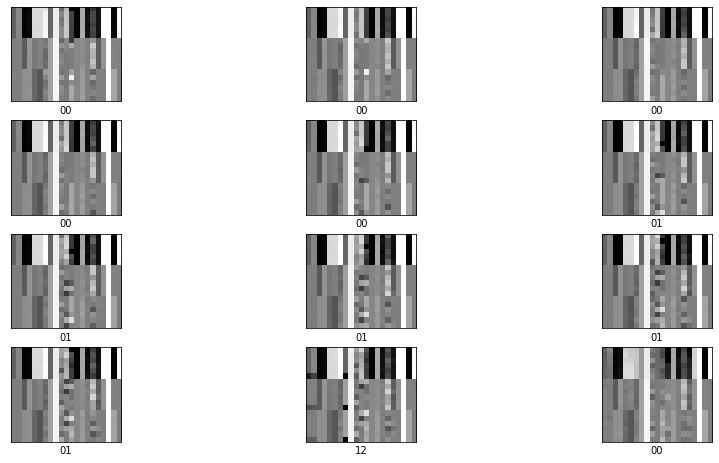

In [42]:
# Compare results in a display of images
print('Image and prediction for Image 244 through 255')
plt.figure(figsize=(15,8))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i+244], cmap='gray')
    plt.xlabel(str(lbl[i+244]) + str(Y[i+244])) #(class_labels[y_pred[i+j]]+' '+str(y_pred[i+j]==y_test[i+j]))
plt.show()

### Above you can see some differences between normal operation ans warnings conditions. There is a development of a checkerboard in the center of the images until at the paper break an indicator appears on the left.
### Below is a plot of the increment between images of the 12 images above. (The difference of each image vs. the prior image.) This makes it easier to see changes approaching a break.

Image and prediction for Image 243 through 254, Left label is original 0,1; right label is 1 for warning & 2 for break


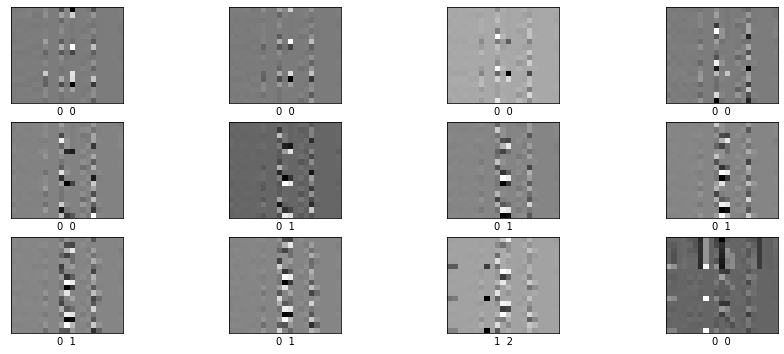

In [43]:
# Compare the difference of subsequent images from the first image
print('Image and prediction for Image 243 through 254, Left label is original 0,1; right label is 1 for warning & 2 for break')
plt.figure(figsize=(15,6))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i+244]-images[i+243], cmap='gray')
    plt.xlabel(str(lbl[i+244]) + '  ' +  str(Y[i+244]))
plt.show()

### Below is an example of two breaks almost back to back at image 2838.  There aren't enough intermediate samples to build enough images for the warning label to go to zero (five warning time slices are represented by this single image before the paper break).

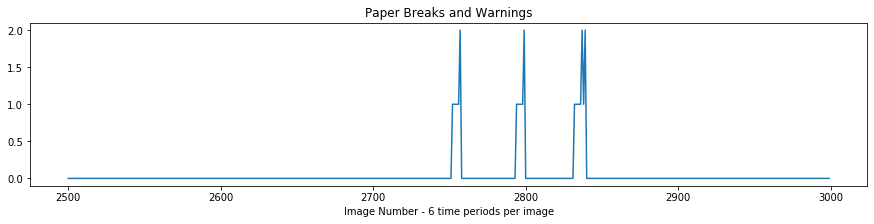

In [44]:
plt.figure(figsize=(15,3))
plt.plot(range(2500,3000),Y[2500:3000])
plt.title("Paper Breaks and Warnings")
plt.xlabel('Image Number - 6 time periods per image')
plt.show()

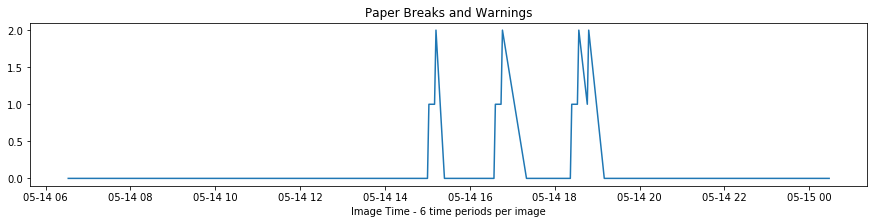

In [45]:
plt.figure(figsize=(15,3))
plt.plot(img_index[2500:3000], Y[2500:3000])
plt.title("Paper Breaks and Warnings")
plt.xlabel('Image Time - 6 time periods per image')
plt.show()

### The backward slopes following a paper break are the gap until the machine starts again and there are 6 running time periods, which are stamped with the last of the 6 time periods. The last spike is only 7 time periods from the previous break as detailed below.

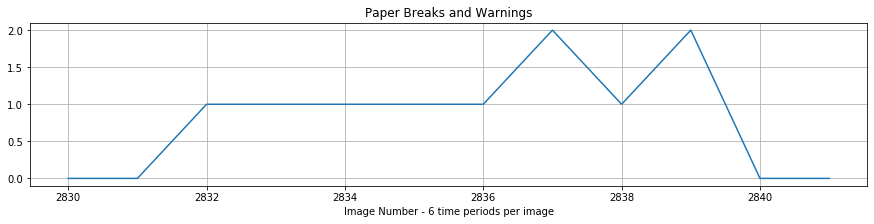

In [46]:
plt.figure(figsize=(15,3))
plt.plot(range(2830,2842), Y[2830:2842])
plt.title("Paper Breaks and Warnings")
plt.xlabel('Image Number - 6 time periods per image')
plt.grid()
plt.show()

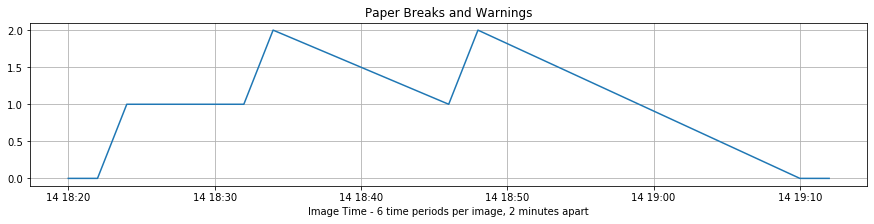

In [47]:
plt.figure(figsize=(15,3))
plt.plot(img_index[2830:2842], Y[2830:2842])
plt.title("Paper Breaks and Warnings")
plt.xlabel('Image Time - 6 time periods per image, 2 minutes apart')
plt.grid()
plt.show()

#### The forth spike in the upper chart is shown in detail above and  shows a case where two breaks occur back to back.  The trailing break is 7 samples after the first.  Image 2837 has the last time sample labelled 2.  Image 2838 has the last time sample with label 1 then image 2839 increments one time sample and again has the last time sample labelled as 2.   Image 2840 has all normal time samples labelled as 0.  The downward sloping lines are the time skips from a fault to the beginning of the next image (either 0 where all 6 time slices are normal or 1 where the at least one slice on the image is within 5 slices of the fault.
#### The no. 2 labels correspond to a 1 label in the original data and the preceeding 5 samples are labelled 0 in the original data.  These 5 are transformed from 0's to 1 and the fault from 1 to 2.

In [48]:
images.size, images.itemsize, images.shape

(2331504, 8, (6168, 18, 21))

#### Now the data is split consistent with the random state from the prior Notebook, but adding the image index so the results can be plotted by time.  The test and train sets will be different because of the change made correcting erroneous paper break labels done above.

In [49]:
# Build train and test set from the image dataset also splitting the image time index.
x_train, x_test, y_train, y_test, train_indx, test_indx = train_test_split(images, Y, img_index, stratify = Y, test_size=0.35, random_state = 0)

In [50]:
x_train.shape, x_test.shape, len(y_train), len(y_test), train_indx.shape, test_indx.shape

((4009, 18, 21), (2159, 18, 21), 4009, 2159, (4009,), (2159,))

In [51]:
tr_s, te_s = x_train.shape[0], x_test.shape[0]
tr_s, te_s

(4009, 2159)

### Save a viewable copy of x_train & x_test to display results.  Reshape the numpy arrays and subtract 0.5 for CNN modelling.


In [52]:
# Save a viewable copy of x_train & x_test to display results
x_te = x_test
x_tr = x_train
x_tr.shape, x_te.shape

((4009, 18, 21), (2159, 18, 21))

In [53]:
x_train = x_train.reshape(tr_s,18,21,1)
x_test = x_test.reshape(te_s,18,21,1)

#### Adjust the CNN input to -0.5 to +0.5

In [54]:
x_train = x_train - 0.5
x_test = x_test - 0.5

### Build a custom predictor to account for dataset imbalance, and a plotting function

In [55]:
def Adjusted_Pred(y_prob, threshold):
    A_prob = np.zeros(y_prob.shape).astype(float)
    A_prob[:,0:3] = y_prob
    
    A_prob[:,1] = A_prob[:,1]*(A_prob[:,1]>=(1-threshold)*5/6)  # Sets prob to 0 if it is less than average frequency of 1
    A_prob[:,2] = A_prob[:,2]*(A_prob[:,2]>=(1-threshold)/6)  # Sets prob to 0 if it is less than average frequency of 2
    for j in range ( len(y_prob) ):
        if sum(A_prob[j,1:3])>0:
            A_prob[j,0] = A_prob[j,0]*(A_prob[j,0]>=threshold)  # normal probability only if probability exceeds the ratio of normals in the set  
    A_pred = A_prob[:,0]
    A_pred = A_prob[:,0:3].argmax(axis=1) 
    return A_pred

In [57]:
def Train_Test_Time_Plot(tracks, actual_tr, pred_tr, prob_tr, Indx_tr, actual_te, pred_te, prob_te, Indx_te, mstr_indx, mkr_size, a, b, title1, fig_height=6, show_normal=True):
    #Rge=range(a,b)
    if tracks == 3:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,fig_height))
    else:
        fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12,fig_height))
        
    ax1.plot(Indx_tr[:], pred_tr[:], label = "Train Prediction", c ='b', ls = 'none', marker = 'x', markersize = mkr_size)
    ax1.plot(Indx_te[:], pred_te[:], label = "Test Prediction", c = 'b', ls = 'none', marker = 'o', markersize = mkr_size)
    ax1.plot(Indx_tr[actual_tr==2], actual_tr[actual_tr==2], label = "Actual Fault",  ls = 'none', marker = 'D', markerfacecolor='none', markeredgecolor='black', markersize = 2*mkr_size)
    ax1.plot(Indx_te[actual_te==2], actual_te[actual_te==2], ls = 'none', marker = 'D', markerfacecolor='none', markeredgecolor='black', markersize = 2*mkr_size)
    ax1.plot(Indx_tr[actual_tr==1], actual_tr[actual_tr==1], label = "Actual Warning", ls = 'none', marker = 'o', markerfacecolor='none', markeredgecolor='gray', markersize = 2*mkr_size)
    ax1.plot(Indx_te[actual_te==1], actual_te[actual_te==1], ls = 'none', marker = 'o', markerfacecolor='none', markeredgecolor='gray', markersize = 2*mkr_size)
    ax1.set_xlim(mstr_indx[a],mstr_indx[b])
    ax1.legend()
    if tracks == 3:
        ax2.plot(Indx_tr[:], actual_tr[:], label ="Actual Label", c ='black', ls = 'none', marker = 'x', markersize = mkr_size)
        ax2.plot(Indx_te[:], actual_te[:], label ="Actual Label", c ='red', ls = 'none', marker = 'D', markersize = mkr_size)
        ax2.set_xlim(mstr_indx[a],mstr_indx[b])
        ax2.set_title('Actual Label, 2 = Fault, 1 = Warning')
    
    if show_normal == True:
        ax3.plot(Indx_tr[:], prob_tr[:,0], label ="Train Normal", c='g', ls = 'none', marker = 'x', markersize = mkr_size) 
        ax3.plot(Indx_te[:], prob_te[:,0], label ="Test Normal", c='g', ls = 'none', marker = 'o', markersize = mkr_size) 
        
    ax3.plot(Indx_tr[:], prob_tr[:,1], label ="Train Warning", c='gold', ls = 'none', marker = 'x', markersize = mkr_size)
    ax3.plot(Indx_te[:], prob_te[:,1], label ="Test Warning", c='gold', ls = 'none', marker = 'o', markersize = mkr_size)
    
    ax3.plot(Indx_tr[:], prob_tr[:,2], label ="Train Fault", c = 'r', ls = 'none', marker = 'x', markersize = mkr_size)
    ax3.plot(Indx_te[:], prob_te[:,2], label ="Test Fault", c = 'r', ls = 'none', marker = 'o', markersize = mkr_size)
    ax3.set_xlim(mstr_indx[a],mstr_indx[b])
    ax3.legend()
    ax1.set_title(('{}{}{}').format('Predicted Impending Fault on ', title1, '\n  Prediction'))
    
    ax3.set_title('Probability of Class')
    plt.xlabel('Day - Time')
    #plt.legend()
    plt.tight_layout()
    plt.show()

### Build a CNN model and fit.

In [58]:
# Build Model
#sgd = optimizers.SGD(lr=0.005, decay=5e-4, momentum=0.5, nesterov=False)

model = Sequential()
model.add(Conv2D(6, (3,3), input_shape = (18, Ws, 1), activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(6, (3,3), activation = 'relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))

model.add(Dropout(0.15))
model.add(Dense(units = 64, activation = 'relu'))

model.add(Dense(units = 3, activation = 'softmax'))
model.compile(optimizer = 'adamax', loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [59]:
live_plot = livelossplot.PlotLossesKeras()

early_stop = EarlyStopping(monitor='val_loss', patience=50, 
                           verbose=0, mode='auto', baseline=None, restore_best_weights=True)

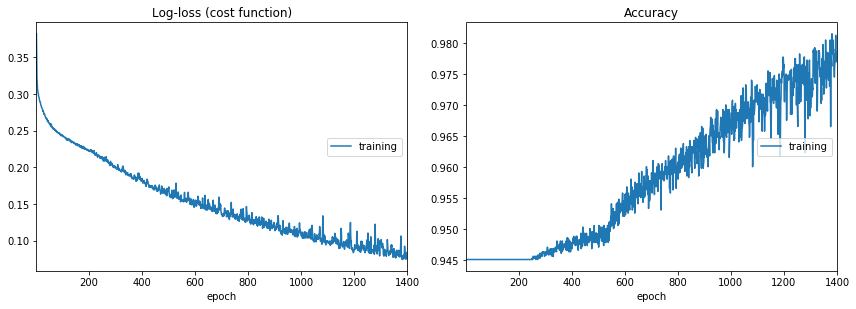

Log-loss (cost function):
training   (min:    0.074, max:    0.947, cur:    0.078)

Accuracy:
training   (min:    0.938, max:    0.982, cur:    0.979)


In [60]:
# Fit the model & train for 100 epochs initially, livelossplot in callbacks, validation split 
# and higher batch size to improve speed
model.fit(x_train, y_train, validation_split = 0.0, callbacks = [live_plot, early_stop], initial_epoch = 0, epochs = 1400, batch_size = 512)

In [64]:
#  Set threshold for the normal class
TH_N = 1-(one+two)/6168   # 1 minus the average frequency for labels 1 through 2
TH_N

0.945201037613489

### x_test performance

In [65]:
y_prob = model.predict_proba(x_test)
a_pred = Adjusted_Pred(y_prob, TH_N)
y_pred = model.predict(x_test).argmax(axis=1)

In [66]:
x_test_cm = confusion_matrix(y_test,a_pred)
print('x_test Confusion Matrix - Adjusted Prediction')
x_test_cm

x_test Confusion Matrix - Adjusted Prediction


array([[1799,  235,    7],
       [  30,   63,    5],
       [   6,    5,    9]], dtype=int64)

#### With the Adjusted Prediction, faults are classified properly, warning class (1) are correctly classified about 60% of the time and 12% of normals are misclassified as warning class.
#### The Adjusted prediction accounts for the imbalance in the dataset where 94.5% are normal.  If the predict_proba function returns less than 94.5% probability for a normal prediction, then either the warning or fault case is predicted. The probability must be above the frequency of occurance to predict each outcome.   

In [67]:
CM = confusion_matrix(y_test,y_pred)
print('x_test Confusion Matrix - ArgMax' )
CM

x_test Confusion Matrix - ArgMax


array([[1982,   57,    2],
       [  60,   36,    2],
       [  10,    3,    7]], dtype=int64)

#### With normal argmax prediction, the test set confusion matrix shows poorer performance with only 37% of warning class samples correctly classified.  The false positive (normals classified as warning class) is around 3%.  The classification report for the Adjusted Prediction is shown below.

In [68]:
print('x_test classification report - Adjusted Prediction \n\n',classification_report(y_test,a_pred))

x_test classification report - Adjusted Prediction 

               precision    recall  f1-score   support

           0       0.98      0.88      0.93      2041
           1       0.21      0.64      0.31        98
           2       0.43      0.45      0.44        20

    accuracy                           0.87      2159
   macro avg       0.54      0.66      0.56      2159
weighted avg       0.94      0.87      0.90      2159



### Here is the x_train fitting performance. This is calculated to plot all predicted samples in time with either test or train origination shown in the chart.

In [69]:
y_prob_train = model.predict_proba(x_train)
a_pred_train = Adjusted_Pred(y_prob_train, TH_N)

In [70]:
x_train_cm = confusion_matrix(y_train,a_pred_train)
print('x_train confusion matrix - Adjusted Prediction')
x_train_cm

x_train confusion matrix - Adjusted Prediction


array([[3421,  359,    9],
       [   0,  181,    1],
       [   1,   13,   24]], dtype=int64)

#### The training fit well to the faults and identified almost all of the warning class.  The model isn't general enough to be as consistent in the test set prediction.  10% of normal samples are predicted as warning class 1.  This may be error in the model, or these false positives samples are more similar to the warning samples prior to actual faults. In other words, the running condition may have been close to a fault condition but the control system recovered the process deviation.

In [71]:
print('x_train classification report Adjusted Prediction \n\n',classification_report(y_train,a_pred_train))

x_train classification report Adjusted Prediction 

               precision    recall  f1-score   support

           0       1.00      0.90      0.95      3789
           1       0.33      0.99      0.49       182
           2       0.71      0.63      0.67        38

    accuracy                           0.90      4009
   macro avg       0.68      0.84      0.70      4009
weighted avg       0.97      0.90      0.93      4009



### Several charts follow that show the model prediction in the upper track with the actual warning and fault labels. Blue dots are test sample predictions 0, 1, or 2. Blue x's are training predictions. Hollow diamonds are actual sample fault labels and hollow circles are the actual warning labels.

### The lower track shows the probability of each class for each sample: green is normal, yellow is warning, red is a falut or paper break. Dots are from the test set and x's are from the training set.
#### This chart below shows all of the training and test samples for the month which have X28 categorical value of 96. This is about one third of all samples and is the most prevalent. The three breaks are run times with one of the other six categories for feature X28.

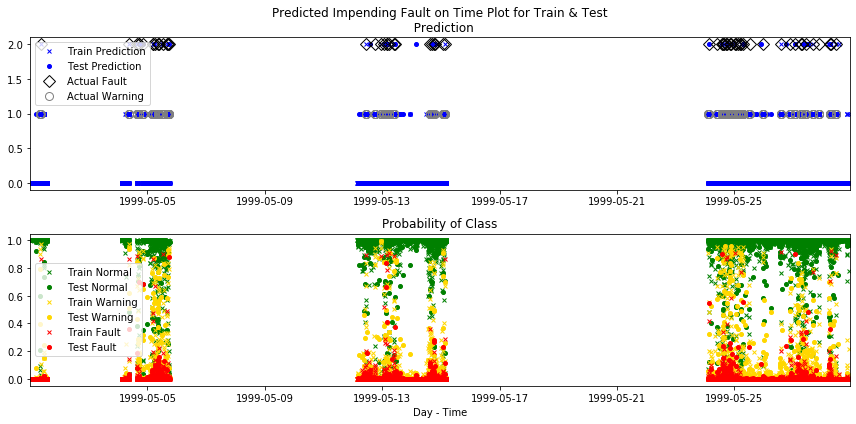

In [72]:
Train_Test_Time_Plot(2, y_train, a_pred_train, y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 0, 6167, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### Below is a 4 hour extract from May 5. This demonstrates where a small decrease in normal probability and a small increase in warning probability shifts the prediction tho a warning state. The gap is the time to restart the paper machine, which then stops again at about 17:15 hours. 

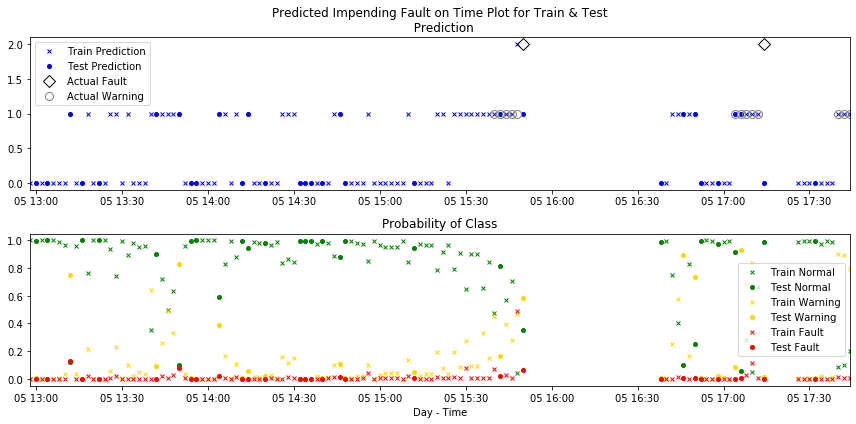

In [73]:
Train_Test_Time_Plot(2, y_train, a_pred_train, y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 985, 1100, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### Below is a the end of a run before the machine was set on another catagorical value (X28) which could be a different paper weight.  The machine was reset to the '96' category on May 4th and had several upsets through to May 5th.

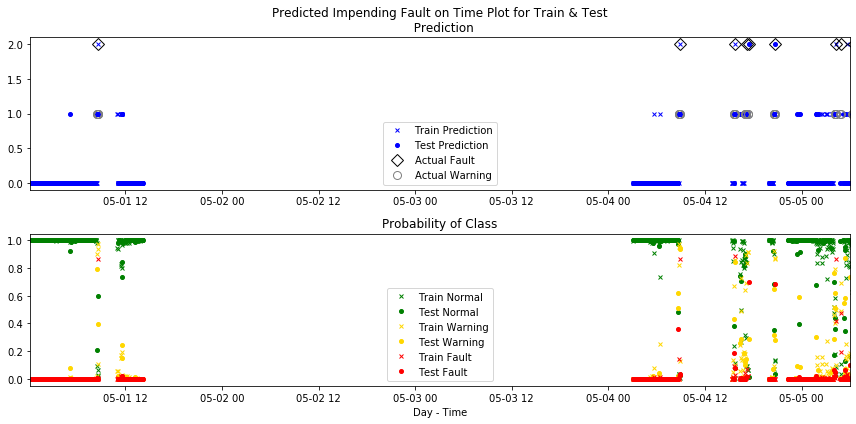

In [74]:
Train_Test_Time_Plot(2, y_train, a_pred_train, y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 0, 800, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### Below is an eleven hour run with six different paper breaks. This is an example of possible deviation from normal that was close to causing a paper break but was recovered or managed by the control system for an extended time before incurring a paper break. 

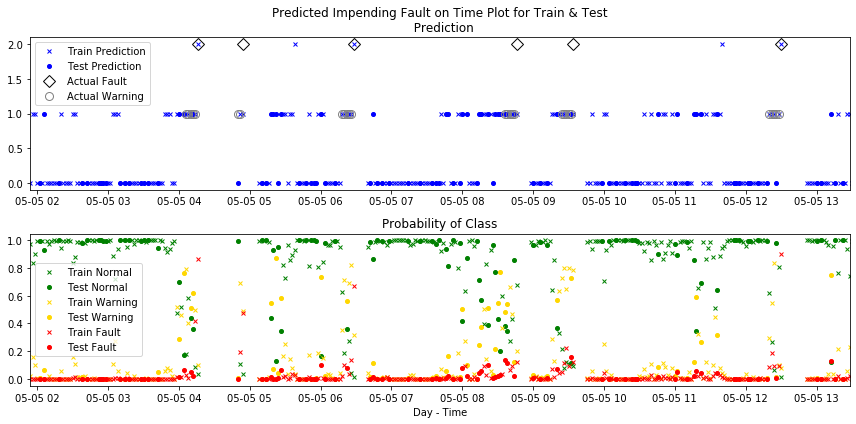

In [75]:
Train_Test_Time_Plot(2, y_train, a_pred_train, y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 700, 1000, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### This 12 hour run with two paper breaks has ''False Warnings" but is generally smoother.  The warnings preceding the paper break are predominantly from the training set.

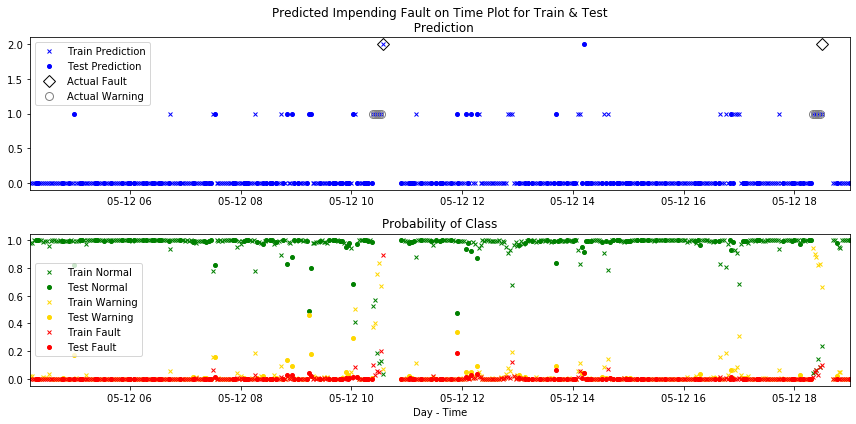

In [76]:
Train_Test_Time_Plot(2, y_train, a_pred_train, y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 1120, 1550, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### This gap in the middle of this chart is from 68 minutes of missing data between 21:38 and 22:50 hours. 

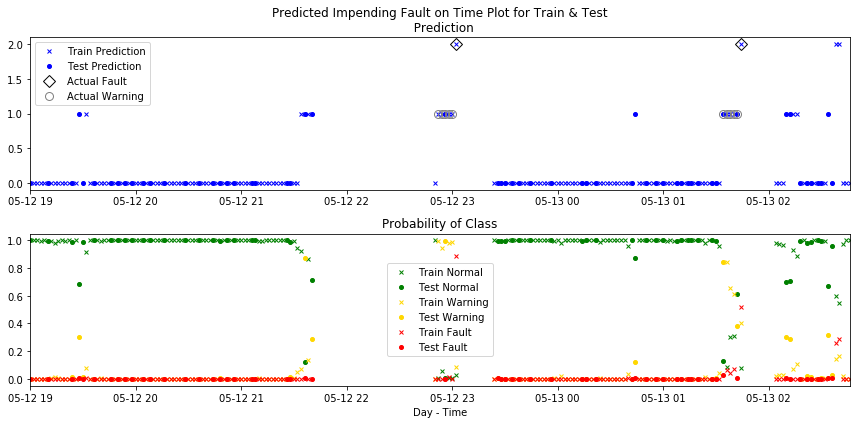

In [77]:
Train_Test_Time_Plot(2, y_train, a_pred_train, y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 1550, 1730, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### Below shows where the group of warning predictions is from the test data (before the two left paper breaks) and also where most of the five warning states were missed by both train and test samples (fourth paper break from the left).

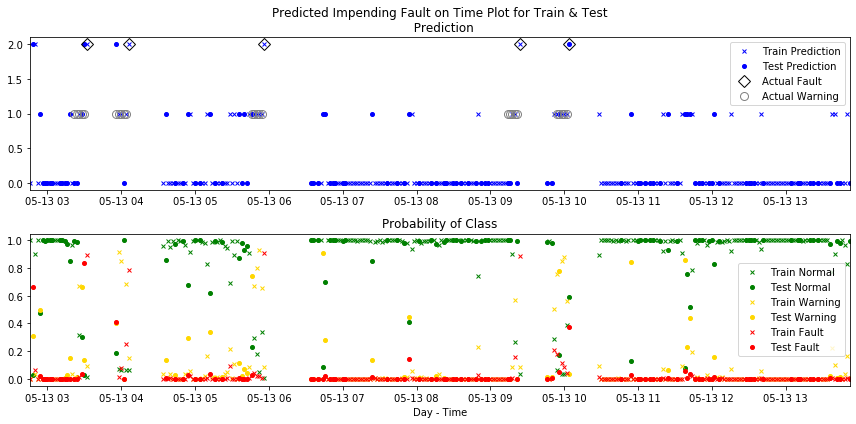

In [78]:
Train_Test_Time_Plot(2, y_train, a_pred_train, y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 1730, 2000, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### Below is a fairly smooth 24 hour running example after false warning in the first few hours. The predictions start to show many warnings after 12pm on the 14th before the paper break at 3pm (15:00 hrs).

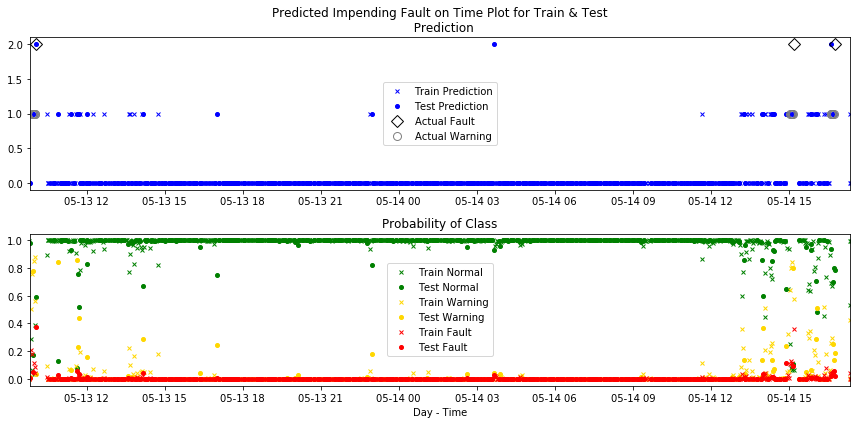

In [79]:
Train_Test_Time_Plot(2, y_train, a_pred_train, y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 1890, 2800, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### Other examples of fairly smooth paper machine operation, but with consistent warnings before the paper breaks.

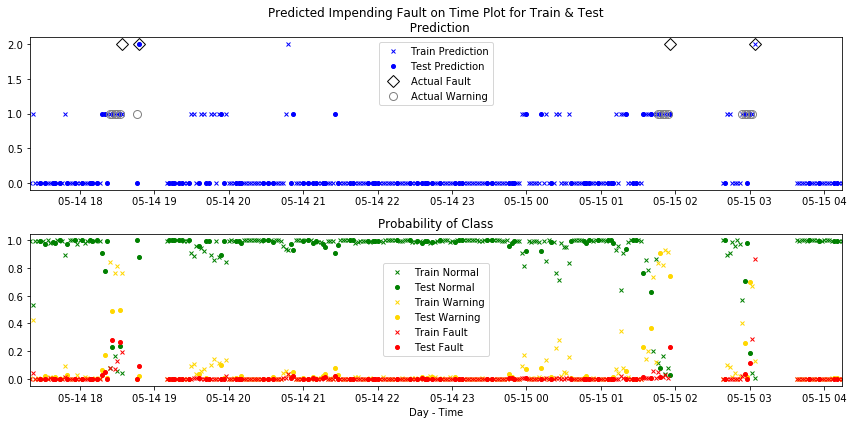

In [80]:
Train_Test_Time_Plot(2, y_train, a_pred_train, y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 2800, 3076, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

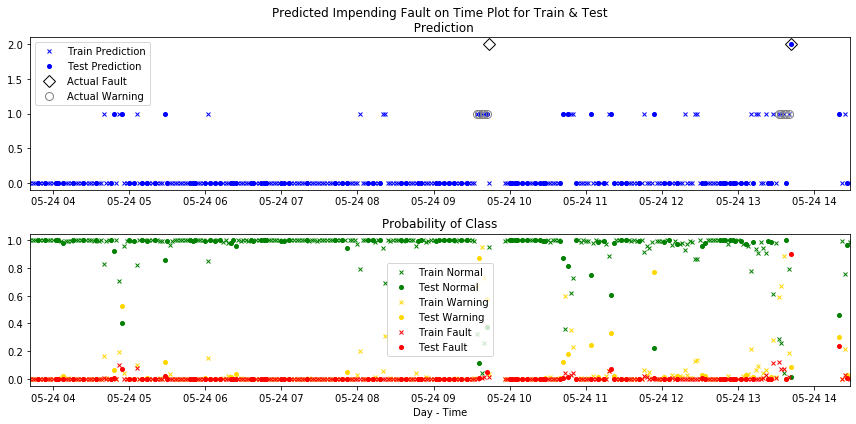

In [81]:
Train_Test_Time_Plot(2, y_train, a_pred_train, y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 3100, 3400, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### Below is a very rough 21 hour operating period with 14 paper breaks.  The predictions are show roughly as many false warning as those that are just prior to the paper breaks. Again, this may be representative of a very chaotic operating condition where the false warning are actually relevant, in that the machine could have been close to an upset at any time.

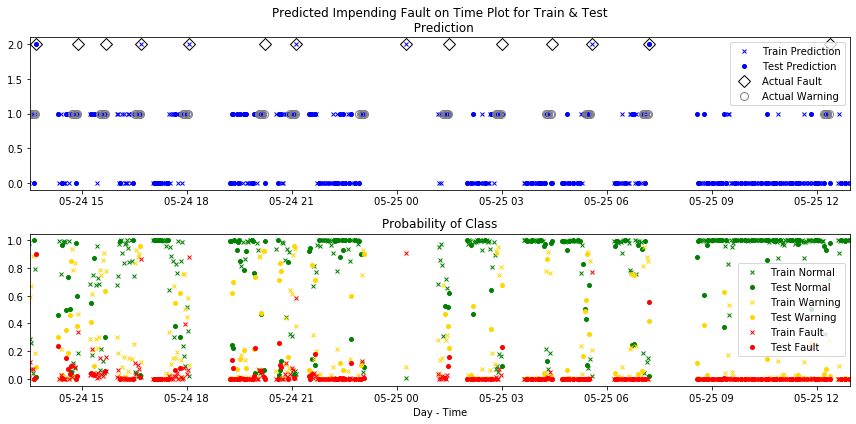

In [82]:
Train_Test_Time_Plot(2, y_train, a_pred_train, y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 3390, 3830, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### In contrast, the eleven hour period below has only one paper break and less than ten false warnings. 

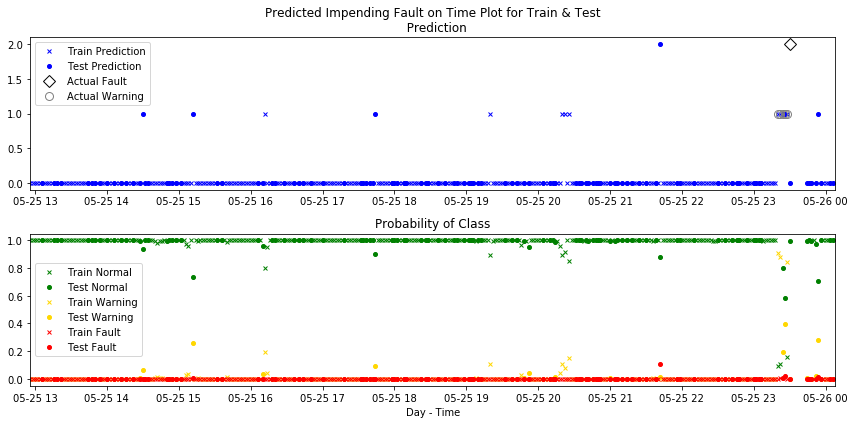

In [83]:
Train_Test_Time_Plot(2, y_train, a_pred_train,y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 3830, 4160, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### The first 10 hours of the chart below has few false warnings and a clean run time. There are many false warnings leading up to the three paper breaks which could be an indication of close calls for the few hours before the actual breaks.

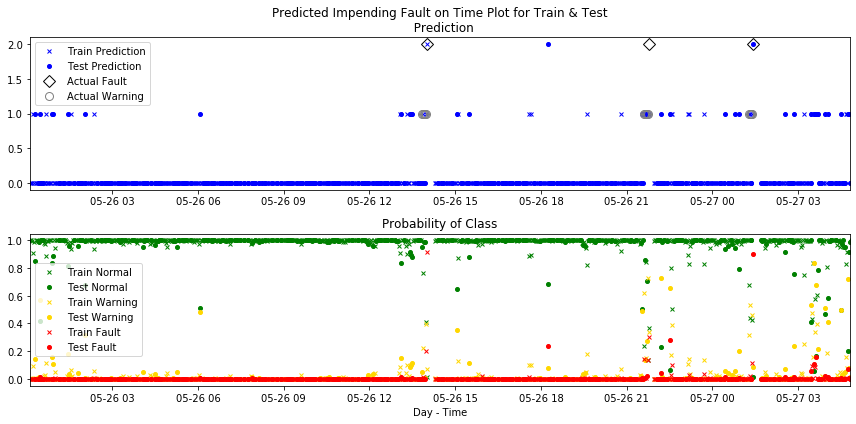

In [84]:
Train_Test_Time_Plot(2, y_train, a_pred_train,y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 4160, 5000, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### The rough high number of false warnings continue through the following two charts with a smooth 8 hour run time at the end of the first chart and a smooth 10 hour run time in the second chart.

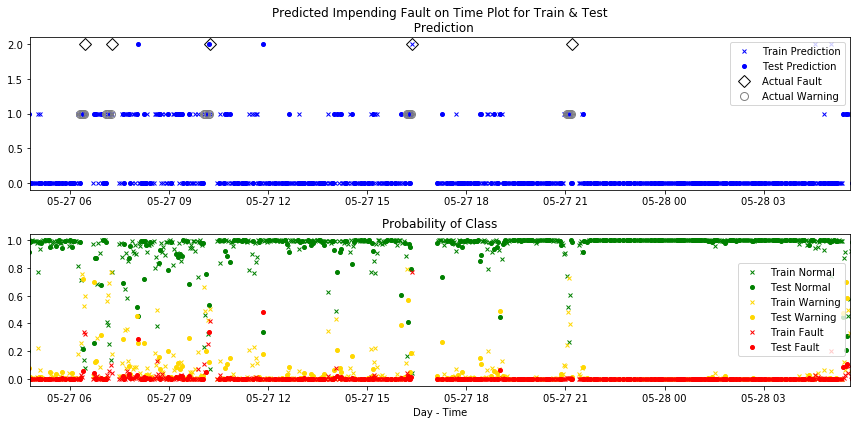

In [85]:
Train_Test_Time_Plot(2, y_train, a_pred_train,y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 5000, 5700, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

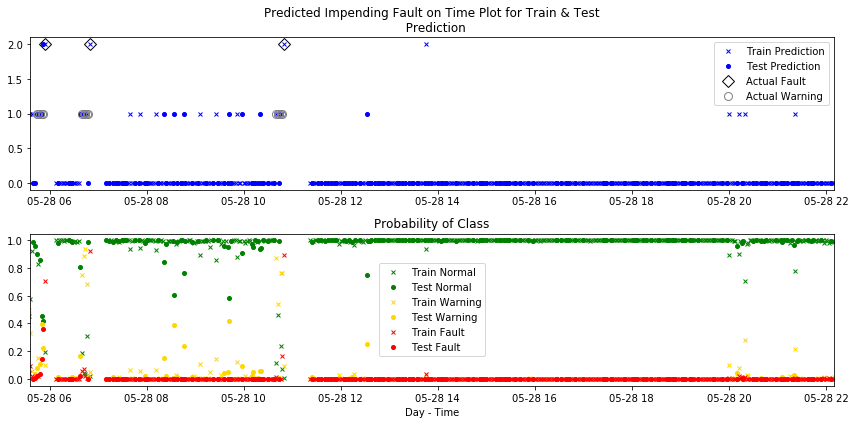

In [86]:
Train_Test_Time_Plot(2, y_train, a_pred_train,y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4, 5700, 6167, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

#### This chart shows the predictions more clearly with a clean 3 hour run time on the right, and shows both test and train samples giving a warning prior to the paper break near 12:30 hours on the 25th.

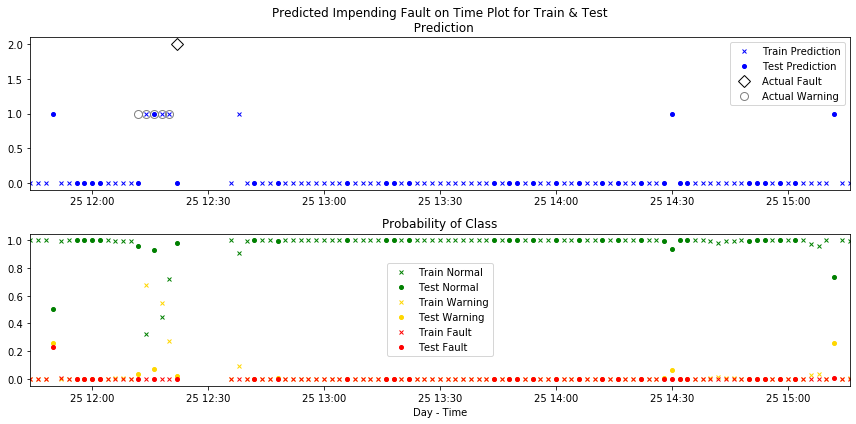

In [87]:
Train_Test_Time_Plot(2, y_train, a_pred_train, y_prob_train, train_indx, y_test, a_pred, y_prob, test_indx, img_index, 4,3800, 3900, 'Time Plot for Train & Test', fig_height=6, show_normal=True)

In [88]:
# Save model
model.save("PaperMachine_SheetBreak_DVA_model_adamax_x28_96_3Class_220710_3.h5")